# MNIST Handwritten Digit Classification Dataset  
The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.  
  
It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.  
  
The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.  
  
It is a widely used and deeply understood dataset and, for the most part, is “solved.” Top-performing models are deep learning convolutional neural networks that achieve a classification accuracy of above 99%, with an error rate between 0.4 %and 0.2% on the hold out test dataset.  
  
The example below loads the MNIST dataset using the Keras API and creates a plot of the first nine images in the training dataset.  

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


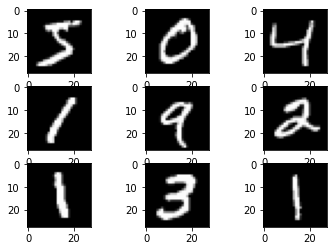

In [1]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

Running the example loads the MNIST train and test dataset and prints their shape.  
  
We can see that there are 60,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 28×28 pixels.  
  
A plot of the first nine images in the dataset is also created showing the natural handwritten nature of the images to be classified.  
  
# Model Evaluation Methodology  
Although the MNIST dataset is effectively solved, it can be a useful starting point for developing and practicing a methodology for solving image classification tasks using convolutional neural networks.  
  
Instead of reviewing the literature on well-performing models on the dataset, we can develop a new model from scratch.  

The dataset already has a well-defined train and test dataset that we can use.  
  
In order to estimate the performance of a model for a given training run, we can further split the training set into a train and validation dataset. Performance on the train and validation dataset over each run can then be plotted to provide learning curves and insight into how well a model is learning the problem.  

The Keras API supports this by specifying the “validation_data” argument to the model.fit() function when training the model, that will, in turn, return an object that describes model performance for the chosen loss and metrics on each training epoch.  
```
# record model performance on a validation dataset during training
history = model.fit(..., validation_data=(valX, valY))
```
In order to estimate the performance of a model on the problem in general, we can use [k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/), perhaps five-fold cross-validation. This will give some account of the models variance with both respect to differences in the training and test datasets, and in terms of the stochastic nature of the learning algorithm. The performance of a model can be taken as the mean performance across k-folds, given the standard deviation, that could be used to estimate a confidence interval if desired.  
  
We can use the [KFold class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) from the scikit-learn API to implement the k-fold cross-validation evaluation of a given neural network model. There are many ways to achieve this, although we can choose a flexible approach where the KFold class is only used to specify the row indexes used for each spit.  
```
# example of k-fold cv for a neural net
data = ...
# prepare cross validation
kfold = KFold(5, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in kfold.split(data):
        model = ...
	...
```  
  
We will hold back the actual test dataset and use it as an evaluation of our final model.  
  
# How to Develop a Baseline Model  
The first step is to develop a baseline model.  

This is critical as it both involves developing the infrastructure for the test harness so that any model we design can be evaluated on the dataset, and it establishes a baseline in model performance on the problem, by which all improvements can be compared.  
  
The design of the test harness is modular, and we can develop a separate function for each piece. This allows a given aspect of the test harness to be modified or inter-changed, if we desire, separately from the rest.  
  
We can develop this test harness with five key elements. They are the loading of the dataset, the preparation of the dataset, the definition of the model, the evaluation of the model, and the presentation of results.  
  
## Load Dataset  
We know some things about the dataset.  
  
For example, we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale.  
  
Therefore, we can load the images and reshape the data arrays to have a single color channel.  
  
```
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
```  
We also know that there are 10 classes and that classes are represented as unique integers.  
  
We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the to_categorical() utility function.  
  
```
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)
```  
  
The load_dataset() function implements these behaviors and can be used to load the dataset.

In [20]:
from tensorflow.keras.utils import to_categorical

# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

## Prepare Pixel Data  
We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.  
  
We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.  

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.  
  
```
# convert from integers to floats
train_norm = train.astype('float32')
test_norm = test.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0
```  
The prep_pixels() function below implements these behaviors and is provided with the pixel values for both the train and test datasets that will need to be scaled.  

In [21]:
train = trainX
test = testX

# convert from integers to floats
train_norm = train.astype('float32')
test_norm = test.astype('float32')
# normalize to range 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

## Define Model  
Next, we need to define a baseline convolutional neural network model for the problem.  
  
The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.  

For the convolutional front-end, we can start with a single [convolutional layer](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) with a small filter size (3,3) and a modest number of filters (32) followed by a [max pooling layer](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/). The filter maps can then be flattened to provide features to the classifier.  
  
Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.  
  
All layers will use the [ReLU activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) and the He weight initialization scheme, both best practices.  
  
We will use a conservative configuration for the stochastic gradient descent optimizer with a [learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) of 0.01 and a momentum of 0.9. The [categorical cross-entropy](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.  

The define_model() function below will define and return this model.  

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Evaluate Model  
After the model is defined, we need to evaluate it.  

The model will be evaluated using [five-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.  
  
The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.  

We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.  
  
The evaluate_model() function below implements these behaviors, taking the training dataset as arguments and returning a list of accuracy scores and training histories that can be later summarized.  

In [13]:
from sklearn.model_selection import KFold

# evaluate a model using k-fold cross-validation
dataX = trainX
dataY = trainY
n_folds=5

scores, histories = list(), list()
# prepare cross validation
kfold = KFold(n_folds, shuffle=True, random_state=1)
# enumerate splits
for train_ix, test_ix in kfold.split(dataX):
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    histories.append(history)

> 88.533
> 89.000
> 89.950
> 90.808
> 90.692


## Present Results
Once the model has been evaluated, we can present the results.  
  
There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. These can be implemented using separate functions.  
  
First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.  

We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. The summarize_diagnostics() function below creates and shows this plot given the collected training histories.  

<ipython-input-15-80b906a179b0>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 1)
<ipython-input-15-80b906a179b0>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 2)


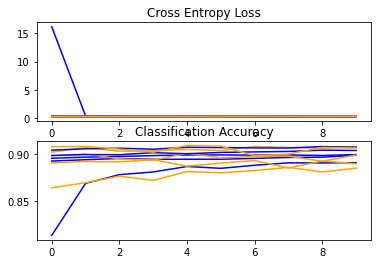

In [15]:
from matplotlib import pyplot

for i in range(len(histories)):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
pyplot.show()

Next, the classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.  
  
The summarize_performance() function below implements this for a given list of scores collected during model evaluation.  

Accuracy: mean=89.797 std=0.903, n=5


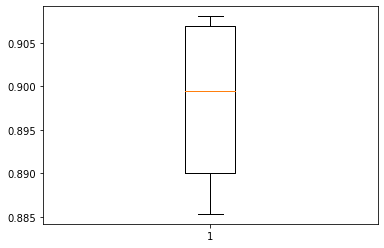

In [16]:
from numpy import mean, std

# print summary
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# box and whisker plots of results
pyplot.boxplot(scores)
pyplot.show()

# How to Finalize the Model and Make Predictions
The process of model improvement may continue for as long as we have ideas and the time and resources to test them out.  
  
At some point, a final model configuration must be chosen and adopted. In this case, we will choose the deeper model as our final model.  

First, we will finalize our model, but fitting a model on the entire training dataset and saving the model to file for later use. We will then load the model and evaluate its performance on the hold out test dataset to get an idea of how well the chosen model actually performs in practice. Finally, we will use the saved model to make a prediction on a single image.  
  
## Save Final Model  
A final model is typically fit on all available data, such as the combination of all train and test dataset.  
  
In this tutorial, we are intentionally holding back a test dataset so that we can estimate the performance of the final model, which can be a good idea in practice. As such, we will fit our model on the training dataset only.  
  
```
# fit model
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
```  
  
Once fit, we can save the final model to an H5 file by calling the save() function on the model and pass in the chosen filename.
  
```
# save model
model.save('final_model.h5')
```

Note, saving and loading a Keras model requires that the [h5py library](https://www.h5py.org/) is installed on your workstation.  
  
The complete example of fitting the final deep model on the training dataset and saving it to file is listed below.  

In [17]:
# save model
model.save('hand-written-digit.h5')

## Evaluate Final Model
We can now load the final model and evaluate it on the hold out test dataset.  

This is something we might do if we were interested in presenting the performance of the chosen model to project stakeholders.  

The model can be loaded via the load_model() function.  

The complete example of loading the saved model and evaluating it on the test dataset is listed below.  
  
Running the example loads the saved model and evaluates the model on the hold out test dataset.

In [22]:
from tensorflow.keras.models import load_model

# evaluate model on test dataset
model = load_model('hand-written-digit.h5')
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 90.480


## Make Prediction
We can use our saved model to make a prediction on new images.  

The model assumes that new images are grayscale, that they have been aligned so that one image contains one centered handwritten digit, and that the size of the image is square with the size 28×28 pixels.  

Below is an image extracted from the MNIST test dataset. You can save it in your current working directory with the filename ‘sample_image.png‘.  
<img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/sample_image.png' alt='Handwritten Digit 7' width='300px' height='300px' />
  
* [Download the sample image (sample_image.png)](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/sample_image.png)  
  
We will pretend this is an entirely new and unseen image, prepared in the required way, and see how we might use our saved model to predict the integer that the image represents (e.g. we expect “7“).  

First, we can load the image, force it to be in grayscale format, and force the size to be 28×28 pixels. The loaded image can then be resized to have a single channel and represent a single sample in a dataset. The load_image() function implements this and will return the loaded image ready for classification.  

Importantly, the pixel values are prepared in the same way as the pixel values were prepared for the training dataset when fitting the final model, in this case, normalized.  
  
```
# load the image
img = load_img(filename, grayscale=True, target_size=(28, 28))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 1 channel
img = img.reshape(1, 28, 28, 1)
# prepare pixel data
img = img.astype('float32')
img = img / 255.0
return img
```
Next, we can load the model as in the previous section and call the predict_classes() function to predict the digit that the image represents.  
  
```
# predict the class
digit = model.predict_classes(img)
```

The complete example is listed below.

In [23]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# load an image and predict the class
# load and prepare the image
filename = 'sample_image.png'
# load the image
img = load_img(filename, grayscale=True, target_size=(28, 28))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 1 channel
img = img.reshape(1, 28, 28, 1)
# prepare pixel data
img = img.astype('float32')
img = img / 255.0

# load model
model = load_model('hand-written-digit.h5')
# predict the class
digit = model.predict_classes(img)
print(digit[0])

/home/walee/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/home/walee/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7


# References
[How to Develop a CNN for MNIST Handwritten Digit Classification](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/)